# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                   
Sample_071  P01024                              22.803
Sample_112  Q9Y5Y7                              18.662
Sample_190  Q504Y0;Q504Y0-3;Q504Y0-4;Q504Y0-5   13.854
Sample_041  Q13508;Q13508-2;Q13508-3            17.906
Sample_088  P21579                              15.800
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                          
Sample_193  O75976                                     14.819
Sample_103  O95297;O95297-2;O95297-3;O95297-4;Q9UEL6   14.968
Sample_198  B7Z5R6;Q14596;Q14596-2                     14.071
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.651
            A0A075B6Q5                 12.261
            A0A075B6R2                 12.338
            A0A075B6S5                 12.700
            A0A087WSY4                 12.024
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.186
            Q9UI40;Q9UI40-2            11.748
            Q9UIW2                     12.477
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.276
            Q9UP79                     12.536
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.076,15.050,16.842,19.863,15.704,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.690,19.067,...,15.528,15.576,13.967,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.670,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.020,17.705,17.039,16.028,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.845,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.588,15.345,17.084,18.708,14.249,19.433,11.895,11.112
Sample_207,15.739,16.877,15.469,16.898,14.825,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.651,...,16.012,15.178,11.789,15.050,16.842,19.863,14.649,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,14.032,19.067,16.188,...,15.528,15.576,13.871,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.222,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,11.946,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.837,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.200,15.345,17.084,18.708,14.249,19.433,11.965,13.075
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 322.94it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.74it/s]

100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.16it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.48it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.67it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.96it/s]

100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.72it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.02it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.77it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.64it/s]

100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.22it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.35it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.83it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.82it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.74it/s]

100%|██████████| 7/7 [00:01<00:00,  3.29it/s]

100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.97it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.41it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.37it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.00it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.94it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.96it/s]

100%|██████████| 8/8 [00:03<00:00,  2.22it/s]

100%|██████████| 8/8 [00:03<00:00,  2.23it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.43it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.96it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.77it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.42it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.37it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.33it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.90it/s]

100%|██████████| 9/9 [00:02<00:00,  2.67it/s]

100%|██████████| 9/9 [00:02<00:00,  3.15it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.79it/s]

 30%|███       | 3/10 [00:00<00:01,  3.77it/s]

 40%|████      | 4/10 [00:01<00:01,  3.45it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.46it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.81it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.41it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.28it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.24it/s]

100%|██████████| 10/10 [00:03<00:00,  2.36it/s]

100%|██████████| 10/10 [00:03<00:00,  2.69it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.22it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.18it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.94it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.45it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.21it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.08it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.08it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.24it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.33it/s]

100%|██████████| 11/11 [00:04<00:00,  2.20it/s]

100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.59it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.59it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.17it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.03it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.14it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  2.25it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.36it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.12it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.00it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  2.00it/s]

100%|██████████| 12/12 [00:05<00:00,  2.07it/s]

100%|██████████| 12/12 [00:05<00:00,  2.18it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.67it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.40it/s]

 31%|███       | 4/13 [00:00<00:02,  3.92it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.06it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.68it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.44it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.32it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.43it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.57it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.64it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.83it/s]

100%|██████████| 13/13 [00:04<00:00,  2.96it/s]

100%|██████████| 13/13 [00:04<00:00,  2.90it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.54it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.01it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.82it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.81it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.86it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.78it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.81it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.86it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.87it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.89it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.92it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.09it/s]

100%|██████████| 14/14 [00:04<00:00,  3.11it/s]

100%|██████████| 14/14 [00:04<00:00,  2.98it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.43it/s]

 20%|██        | 3/15 [00:00<00:02,  4.22it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.32it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.50it/s]

 40%|████      | 6/15 [00:01<00:02,  3.36it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.18it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.16it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.21it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.23it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.25it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.21it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.25it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.90it/s]

100%|██████████| 15/15 [00:04<00:00,  2.62it/s]

100%|██████████| 15/15 [00:04<00:00,  3.16it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.053 0.018          0.736 0.369       0.109   
2             0.004 0.002      0.064 0.024          0.758 0.090       0.709   
3             0.006 0.005      0.069 0.025          0.755 0.088       0.712   
4             0.004 0.002      0.049 0.008          0.789 0.097       0.778   
5             0.004 0.002      0.041 0.013          0.779 0.088       0.778   
6             0.004 0.002      0.053 0.013          0.782 0.089       0.793   
7             0.004 0.002      0.051 0.017          0.839 0.082       0.819   
8             0.004 0.000      0.053 0.016          0.842 0.076       0.821   
9             0.005 0.004      0.066 0.023          0.833 0.074       0.819   
10            0.004 0.002      0.057 0.022          0.828 0.072       0.812   
11            0.008 0.007      0.089 0.035          0.828 0.075       0.808   
12            0.006 0.005      0.072 0.032          0.823 0.075       0.809   
13            0.003 0.001      0.035 0.013          0.823 0.075       0.807   
14            0.005 0.004      0.052 0.019          0.819 0.087       0.811   
15            0.007 0.006      0.087 0.029          0.817 0.089       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.182 0.129                  0.547 0.040        0.855   
2          0.092   0.726 0.060                  0.768 0.048        0.856   
3          0.087   0.728 0.066                  0.769 0.053        0.857   
4          0.095   0.779 0.072                  0.810 0.062        0.894   
5          0.091   0.774 0.065                  0.806 0.056        0.898   
6          0.096   0.783 0.071                  0.814 0.062        0.897   
7          0.101   0.824 0.071                  0.850 0.060        0.912   
8          0.102   0.827 0.069                  0.853 0.058        0.911   
9          0.093   0.822 0.065                  0.848 0.055        0.912   
10         0.099   0.817 0.069                  0.844 0.057        0.910   
11         0.098   0.815 0.070                  0.842 0.058        0.910   
12         0.096   0.813 0.069                  0.840 0.057        0.908   
13         0.094   0.811 0.066                  0.839 0.055        0.907   
14         0.095   0.811 0.070                  0.838 0.060        0.909   
15         0.097   0.809 0.071                  0.836 0.060        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.825 0.089        210.000 0.000  
2          0.060                  0.833 0.067        210.000 0.000  
3          0.059                  0.839 0.066        210.000 0.000  
4          0.053                  0.878 0.060        210.000 0.000  
5          0.049                  0.883 0.052        210.000 0.000  
6          0.050                  0.882 0.054        210.000 0.000  
7          0.053                  0.898 0.056        210.000 0.000  
8          0.053                  0.898 0.057        210.000 0.000  
9          0.053                  0.900 0.056        210.000 0.000  
10         0.054                  0.898 0.056        210.000 0.000  
11         0.055                  0.897 0.058        210.000 0.000  
12         0.055                  0.895 0.059        210.000 0.000  
13         0.056                  0.892 0.060        210.000 0.000  
14         0.054                  0.898 0.056        210.000 0.000  
15         0.053                  0.895 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 503.28it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.16it/s]

100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.37it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.70it/s]

100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.41it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.93it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.50it/s]

100%|██████████| 5/5 [00:01<00:00,  2.25it/s]

100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.49it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.43it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.32it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.22it/s]

100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

100%|██████████| 6/6 [00:02<00:00,  2.38it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.24it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.10it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.75it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.66it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.56it/s]

100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.42it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.34it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.17it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.17it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

100%|██████████| 8/8 [00:03<00:00,  2.34it/s]

100%|██████████| 8/8 [00:03<00:00,  2.32it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.56it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.51it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.82it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.78it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.99it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.88it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.79it/s]

100%|██████████| 9/9 [00:03<00:00,  2.82it/s]

100%|██████████| 9/9 [00:03<00:00,  2.96it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.00it/s]

 30%|███       | 3/10 [00:00<00:01,  3.54it/s]

 40%|████      | 4/10 [00:01<00:01,  3.07it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.83it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.46it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.19it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.05it/s]

 90%|█████████ | 9/10 [00:03<00:00,  1.98it/s]

100%|██████████| 10/10 [00:04<00:00,  1.99it/s]

100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:03,  2.71it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.23it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.04it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.08it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.12it/s]

 64%|██████▎   | 7/11 [00:03<00:01,  2.24it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.31it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.37it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.46it/s]

100%|██████████| 11/11 [00:04<00:00,  2.55it/s]

100%|██████████| 11/11 [00:04<00:00,  2.34it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.51it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.87it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.41it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.60it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.79it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.83it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.80it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.77it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.80it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.78it/s]

100%|██████████| 12/12 [00:04<00:00,  2.80it/s]

100%|██████████| 12/12 [00:04<00:00,  2.81it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.70it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.47it/s]

 31%|███       | 4/13 [00:01<00:03,  2.90it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.86it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.82it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.83it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.80it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.83it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.54it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.36it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.11it/s]

100%|██████████| 13/13 [00:05<00:00,  1.90it/s]

100%|██████████| 13/13 [00:05<00:00,  2.47it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.76it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.79it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.34it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.94it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.36it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.12it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.10it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.14it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.27it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.25it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.38it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.95it/s]

100%|██████████| 14/14 [00:06<00:00,  1.87it/s]

100%|██████████| 14/14 [00:06<00:00,  2.27it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  2.68it/s]

 20%|██        | 3/15 [00:01<00:05,  2.02it/s]

 27%|██▋       | 4/15 [00:01<00:05,  1.95it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.97it/s]

 40%|████      | 6/15 [00:02<00:04,  2.01it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.04it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.09it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.13it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.19it/s]

 73%|███████▎  | 11/15 [00:05<00:01,  2.19it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.13it/s]

 87%|████████▋ | 13/15 [00:06<00:00,  2.02it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.88it/s]

100%|██████████| 15/15 [00:07<00:00,  1.90it/s]

100%|██████████| 15/15 [00:07<00:00,  2.03it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.071 0.024          0.000 0.000       0.000   
2             0.005 0.004      0.065 0.034          0.758 0.114       0.590   
3             0.005 0.004      0.065 0.025          0.739 0.128       0.572   
4             0.006 0.005      0.067 0.024          0.727 0.101       0.657   
5             0.004 0.000      0.049 0.008          0.728 0.100       0.651   
6             0.005 0.005      0.060 0.021          0.758 0.093       0.685   
7             0.005 0.004      0.064 0.023          0.743 0.106       0.659   
8             0.005 0.004      0.053 0.022          0.729 0.116       0.666   
9             0.008 0.007      0.076 0.026          0.737 0.112       0.674   
10            0.005 0.004      0.058 0.017          0.775 0.092       0.766   
11            0.007 0.005      0.075 0.028          0.781 0.094       0.771   
12            0.007 0.006      0.085 0.031          0.787 0.087       0.784   
13            0.006 0.005      0.076 0.033          0.793 0.095       0.783   
14            0.005 0.003      0.056 0.022          0.794 0.095       0.786   
15            0.005 0.005      0.050 0.011          0.792 0.094       0.783   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.498 0.006        0.847   
2          0.137   0.653 0.105                  0.723 0.071        0.771   
3          0.135   0.635 0.113                  0.709 0.078        0.765   
4          0.139   0.684 0.107                  0.738 0.083        0.838   
5          0.137   0.681 0.105                  0.736 0.082        0.836   
6          0.130   0.714 0.095                  0.762 0.074        0.844   
7          0.132   0.692 0.102                  0.745 0.079        0.850   
8          0.135   0.690 0.108                  0.741 0.087        0.859   
9          0.129   0.699 0.104                  0.748 0.084        0.858   
10         0.120   0.765 0.087                  0.800 0.073        0.900   
11         0.112   0.771 0.083                  0.804 0.071        0.901   
12         0.113   0.781 0.083                  0.814 0.070        0.907   
13         0.108   0.783 0.081                  0.815 0.068        0.907   
14         0.108   0.785 0.079                  0.816 0.067        0.906   
15         0.109   0.783 0.082                  0.815 0.069        0.905   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.819 0.090        210.000 0.000  
2          0.079                  0.724 0.096        210.000 0.000  
3          0.081                  0.714 0.100        210.000 0.000  
4          0.063                  0.813 0.070        210.000 0.000  
5          0.064                  0.811 0.070        210.000 0.000  
6          0.058                  0.824 0.066        210.000 0.000  
7          0.057                  0.827 0.065        210.000 0.000  
8          0.060                  0.832 0.070        210.000 0.000  
9          0.061                  0.831 0.071        210.000 0.000  
10         0.051                  0.877 0.059        210.000 0.000  
11         0.049                  0.877 0.055        210.000 0.000  
12         0.049                  0.883 0.058        210.000 0.000  
13         0.048                  0.886 0.057        210.000 0.000  
14         0.048                  0.885 0.057        210.000 0.000  
15         0.048                  0.883 0.058 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 906.88it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 23.71it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 16.81it/s]

100%|██████████| 3/3 [00:00<00:00, 15.88it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.80it/s]

100%|██████████| 4/4 [00:00<00:00, 15.95it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 17.55it/s]

100%|██████████| 5/5 [00:00<00:00, 13.20it/s]

100%|██████████| 5/5 [00:00<00:00, 13.71it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 15.14it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 10.73it/s]

100%|██████████| 6/6 [00:00<00:00, 10.96it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 16.22it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 12.28it/s]

100%|██████████| 7/7 [00:00<00:00, 10.13it/s]

100%|██████████| 7/7 [00:00<00:00, 10.95it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 15.91it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 11.63it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 11.02it/s]

100%|██████████| 8/8 [00:00<00:00, 11.17it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 17.91it/s]

 44%|████▍     | 4/9 [00:00<00:00, 12.06it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 12.24it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 11.55it/s]

100%|██████████| 9/9 [00:00<00:00, 12.26it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 16.90it/s]

 40%|████      | 4/10 [00:00<00:00, 13.34it/s]

 60%|██████    | 6/10 [00:00<00:00, 14.12it/s]

 80%|████████  | 8/10 [00:00<00:00, 14.97it/s]

100%|██████████| 10/10 [00:00<00:00, 13.76it/s]

100%|██████████| 10/10 [00:00<00:00, 14.05it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 20.31it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 16.30it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 14.57it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.64it/s]

100%|██████████| 11/11 [00:00<00:00, 14.36it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 15.76it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.23it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.44it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 11.19it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 11.74it/s]

100%|██████████| 12/12 [00:01<00:00, 11.91it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 17.91it/s]

 38%|███▊      | 5/13 [00:00<00:00, 12.35it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 11.18it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.42it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 11.77it/s]

100%|██████████| 13/13 [00:01<00:00, 11.99it/s]

100%|██████████| 13/13 [00:01<00:00, 12.07it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 15.69it/s]

 29%|██▊       | 4/14 [00:00<00:00, 11.20it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.67it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.53it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  9.45it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  9.45it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  8.61it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  8.06it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  8.37it/s]

100%|██████████| 14/14 [00:01<00:00,  8.56it/s]

100%|██████████| 14/14 [00:01<00:00,  9.13it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 15.14it/s]

 33%|███▎      | 5/15 [00:00<00:00, 11.13it/s]

 47%|████▋     | 7/15 [00:00<00:00, 10.05it/s]

 60%|██████    | 9/15 [00:00<00:00,  9.59it/s]

 67%|██████▋   | 10/15 [00:00<00:00,  9.31it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  9.35it/s]

 80%|████████  | 12/15 [00:01<00:00,  9.24it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.25it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.25it/s]

100%|██████████| 15/15 [00:01<00:00,  9.43it/s]

100%|██████████| 15/15 [00:01<00:00,  9.73it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.005      0.083 0.027          0.000 0.000       0.000   
2             0.005 0.003      0.057 0.018          0.661 0.141       0.376   
3             0.004 0.002      0.066 0.026          0.611 0.138       0.369   
4             0.005 0.003      0.075 0.031          0.602 0.145       0.365   
5             0.004 0.002      0.049 0.009          0.603 0.129       0.376   
6             0.007 0.007      0.075 0.029          0.589 0.131       0.377   
7             0.004 0.002      0.047 0.010          0.641 0.098       0.564   
8             0.007 0.006      0.087 0.033          0.637 0.098       0.562   
9             0.007 0.006      0.067 0.023          0.644 0.088       0.573   
10            0.004 0.002      0.048 0.010          0.665 0.096       0.589   
11            0.005 0.003      0.059 0.021          0.660 0.097       0.587   
12            0.004 0.000      0.054 0.020          0.673 0.093       0.616   
13            0.007 0.006      0.087 0.035          0.658 0.094       0.605   
14            0.004 0.001      0.055 0.019          0.658 0.091       0.623   
15            0.006 0.004      0.075 0.026          0.642 0.088       0.611   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.727   
2          0.094   0.470 0.094                  0.612 0.058        0.673   
3          0.091   0.453 0.096                  0.595 0.064        0.663   
4          0.101   0.446 0.101                  0.590 0.067        0.669   
5          0.107   0.456 0.105                  0.596 0.067        0.669   
6          0.109   0.451 0.104                  0.590 0.064        0.659   
7          0.117   0.595 0.097                  0.666 0.073        0.756   
8          0.120   0.592 0.098                  0.664 0.072        0.752   
9          0.119   0.601 0.092                  0.670 0.068        0.751   
10         0.125   0.619 0.102                  0.687 0.074        0.752   
11         0.127   0.615 0.103                  0.683 0.073        0.747   
12         0.119   0.639 0.098                  0.699 0.076        0.771   
13         0.115   0.627 0.097                  0.688 0.075        0.764   
14         0.119   0.636 0.095                  0.694 0.078        0.769   
15         0.118   0.622 0.092                  0.681 0.074        0.767   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.073                  0.680 0.087        210.000 0.000  
2          0.076                  0.622 0.090        210.000 0.000  
3          0.073                  0.605 0.083        210.000 0.000  
4          0.074                  0.599 0.082        210.000 0.000  
5          0.073                  0.601 0.083        210.000 0.000  
6          0.077                  0.600 0.085        210.000 0.000  
7          0.075                  0.705 0.084        210.000 0.000  
8          0.077                  0.699 0.084        210.000 0.000  
9          0.081                  0.702 0.089        210.000 0.000  
10         0.076                  0.700 0.085        210.000 0.000  
11         0.076                  0.695 0.083        210.000 0.000  
12         0.071                  0.722 0.083        210.000 0.000  
13         0.076                  0.718 0.089        210.000 0.000  
14         0.077                  0.724 0.092        210.000 0.000  
15         0.076                  0.716 0.090 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,11,9,8
score_time,11,12,13
test_precision,8,14,12
test_recall,8,14,14
test_f1,8,14,12
test_balanced_accuracy,8,14,12
test_roc_auc,9,13,12
test_average_precision,9,13,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.47it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.60it/s]

 31%|███       | 4/13 [00:01<00:02,  3.29it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.02it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.97it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.89it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.94it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.86it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.18it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.82it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.69it/s]

100%|██████████| 13/13 [00:05<00:00,  1.56it/s]

100%|██████████| 13/13 [00:05<00:00,  2.23it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 14.28it/s]

 42%|████▏     | 5/12 [00:00<00:00,  9.49it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 10.24it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 10.61it/s]

 92%|█████████▏| 11/12 [00:01<00:00, 10.52it/s]

100%|██████████| 12/12 [00:01<00:00, 10.68it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.08it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.86it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.74it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.63it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.25it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.05it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.00it/s]

100%|██████████| 9/9 [00:03<00:00,  2.16it/s]

100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


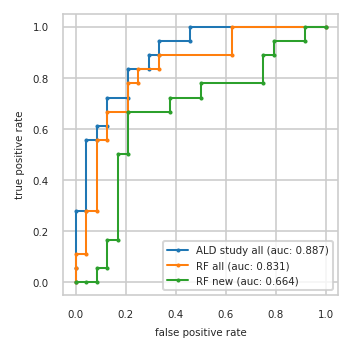

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.278  0.000 0.111  0.083 0.000
3          0.042 0.278  0.042 0.111  0.083 0.056
4          0.042 0.556  0.042 0.278  0.125 0.056
5          0.083 0.556  0.083 0.278  0.125 0.167
6          0.083 0.611  0.083 0.556  0.167 0.167
7          0.125 0.611  0.125 0.556  0.167 0.500
8          0.125 0.722  0.125 0.667  0.208 0.500
9          0.208 0.722  0.208 0.667  0.208 0.667
10         0.208 0.833  0.208 0.778  0.375 0.667
11         0.292 0.833  0.250 0.778  0.375 0.722
12         0.292 0.889  0.250 0.833  0.500 0.722
13         0.333 0.889  0.333 0.833  0.500 0.778
14         0.333 0.944  0.333 0.889  0.750 0.778
15         0.458 0.944  0.625 0.889  0.750 0.889
16         0.458 1.000  0.625 1.000  0.792 0.889
17         1.000 1.000  1.000 1.000  0.792 0.944
18           NaN   NaN    NaN   NaN  0.917 0.944
19           NaN   NaN    NaN   NaN  0.917 1.000
20           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,F5H265,P60709;P63261,K7EPJ5;O60291;O60291-2;O60291-3;O60291-4
2,Q99969,F8WE04;P04792,E5RK69;E7EMC6;P08133;P08133-2
3,P61981,P10636-2;P10636-6,P31150
4,P04075,C9JIZ6;P07602;P07602-2;P07602-3,P31321
5,P14174,P04075,J3KSJ8;Q9UD71;Q9UD71-2
6,Q9Y2T3;Q9Y2T3-3,P61981,Q96GD0
7,P00338;P00338-3,P25189;P25189-2,O95497
8,C9JF17;P05090,P14174,A0A075B7B8


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


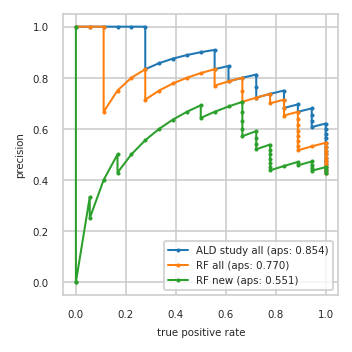

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.531 0.944     0.438 0.778
11         0.581 1.000     0.516 0.889     0.452 0.778
12         0.600 1.000     0.533 0.889     0.467 0.778
13         0.621 1.000     0.552 0.889     0.483 0.778
14         0.607 0.944     0.571 0.889     0.500 0.778
15         0.630 0.944     0.593 0.889     0.519 0.778
16         0.654 0.944     0.615 0.889     0.538 0.778
17         0.680 0.944     0.640 0.889     0.520 0.722
18         0.667 0.889     0.667 0.889     0.542 0.722
19         0.696 0.889     0.652 0.833     0.565 0.722
20         0.682 0.833     0.682 0.833     0.591 0.722
21         0.714 0.833     0.714 0.833     0.571 0.667
22         0.750 0.833     0.700 0.778     0.600 0.667
23         0.737 0.778     0.737 0.778     0.632 0.667
24         0.722 0.722     0.722 0.722     0.667 0.667
25         0.765 0.722     0.706 0.667     0.706 0.667
26         0.812 0.722     0.750 0.667     0.688 0.611
27         0.800 0.667     0.800 0.667     0.667 0.556
28         0.786 0.611     0.786 0.611     0.643 0.500
29         0.846 0.611     0.769 0.556     0.692 0.500
30         0.833 0.556     0.833 0.556     0.667 0.444
31         0.909 0.556     0.818 0.500     0.636 0.389
32         0.900 0.500     0.800 0.444     0.600 0.333
33         0.889 0.444     0.778 0.389     0.556 0.278
34         0.875 0.389     0.750 0.333     0.500 0.222
35         0.857 0.333     0.714 0.278     0.429 0.167
36         0.833 0.278     0.833 0.278     0.500 0.167
37         1.000 0.278     0.800 0.222     0.400 0.111
38         1.000 0.222     0.750 0.167     0.250 0.056
39         1.000 0.167     0.667 0.111     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


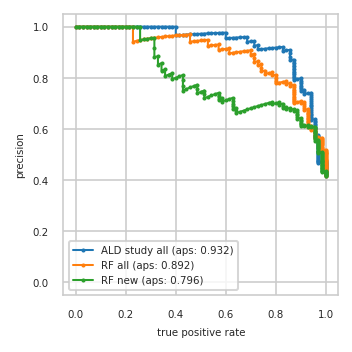

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


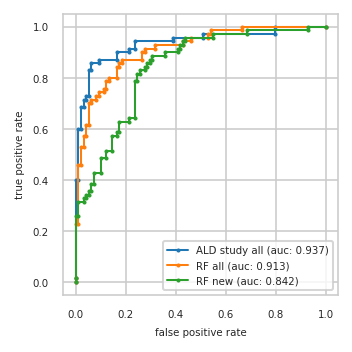

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}